Import necessary libraries

In [1]:
# import necessary libraries
import os
import splitfolders

import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Read data folder and convert it to appropriate for training folder structure

In [2]:
# convert data folders to a convenient data folder structure in order to be read from pytorch
input_dir = './xrays/'
new_data_dir = './xrays_dataset/'
if not os.path.exists('./xrays_dataset/'): 
    os.mkdir('./xrays_dataset/')

# split dataset folders to train/val/test classes folders
splitfolders.ratio( input_dir, # location of raw folders 
                   output=new_data_dir, # location of splitted dataset folders
                   seed=1337, #  
                   ratio=(.8, .1, .1), # The ratio of splited dataset, 80% for training, 10% for validation and test
                   group_prefix=None, # 
                   move=False 
                   )

Define some useful image transforms and normalization

In [16]:
# define some useful and necessary image transformations and normalization as preprocessing steps

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # in case some xray images are given rotated
        transforms.RandomRotation((-20, 20)),        
        # in case some xray images are given zoomed in or zoomed out
        transforms.RandomAffine(0, translate=None, scale=[0.7, 1.3], shear=None),        
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.ToImageTensor(),
        #transforms.ConvertImageDtype(),
        # this normalization for an rgb image is equal to substracting the mean value and dividing by std
        # offline checking returned a mean value of 0.5 for a 3-channel grayscale image
        transforms.Normalize([.22, .22, .22],
                            [.22, .22, .22])

    ]),
    'val': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.ToImageTensor(),
        transforms.Normalize([.22, .22, .22],
                            [.22, .22, .22])

    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        #transforms.ToImageTensor(),
        #transforms.ConvertImageDtype(),
        transforms.Normalize([.22, .22, .22],
                            [.22, .22, .22])

    ])
}



Construct a pytorch ImageFolder Dataset and load data to pytorch Dataloader

In [17]:
# Set train and valid directory paths
train_directory = new_data_dir + '/train'
valid_directory = new_data_dir + '/val'
test_directory = new_data_dir + '/test'

# load data and create train, validation and pytorch dataloaders
data = {'train': torchvision.datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
        'val': torchvision.datasets.ImageFolder(root=valid_directory, transform=image_transforms['val']),
        'test': torchvision.datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])	}

# Batch size
bs = 16

# Create iterators for the Data loaded using DataLoader module
train_dataloader = torch.utils.data.DataLoader(data['train'], batch_size=bs, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(data['val'], batch_size=bs, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(data['test'], batch_size=bs, shuffle=True)


A pretrained CNN model was chosen instead of a new CNN trained from scratch, because it has been shown that for classification and feature extraction purposes it is preferable to use a pretrained-CNN since it has adjusted its parameters in a huge dataset. I have neither the computational capability of such gpu servers, nor sufficient amount of data to train a classifier from scratch with xray images. So, instead I utilize an already trained (on different data but on many seen classes) CNN model and I train a fixed feed-foward neural network which acts as a binary classifier on top of the pretrained CNN. I chose Resnet18 as the pretrained CNN because it is the smaller of the Resnet CNN networks and I chose a Resnet because they have shown very good performance among the pretrained CNNs.

In [5]:
# define the pretrained CNN based binary image classifier

from torchvision import models

class CNN_Model(torch.nn.Module):

	def __init__(self,num_classes=2):
		super().__init__()

		# Load pretrained ResNet50 Model
		#weights = models.ResNet50_Weights.IMAGENET1K_V2
		#preprocess = weights.transforms()
		#self.resnet = models.resnet50('IMAGENET1K_V2')#.to(device)
		self.resnet = models.resnet18(pretrained=True) 

		# freeze model parameters, so as not be updated during training
		for param in self.resnet.parameters():
			param.requires_grad = False

		# change the final layer of ResNet50 Model for Transfer Learning
		# and create a fully connected layer with 1
		fc_inputs = self.resnet.fc.in_features
		self.resnet.fc = torch.nn.Sequential(
			torch.nn.Linear(fc_inputs, 128),
			torch.nn.ReLU(),
			torch.nn.Dropout(0.1),
			torch.nn.Linear(128, num_classes)
            #torch.nn.LogSoftmax(dim=1)
		)

		# set parameters of last layer to be trainable
		for param in self.resnet.fc.parameters():
		    param.requires_grad = True

  #       # also set as updateable the last/fourth layer parameters
		# for param in self.resnet.layer4.parameters():
		# 	param.requires_grad = True
    

	def forward(self, x):
    
		output = self.resnet(x)
		#output = torch.sigmoid(output)
    
		return output

Model initialization

In [6]:
# initiazlize CNN classifier
# 2 classes but one output and a sigmoid decides which class the output belongs to
num_of_classes = 1

# init pretrain model
model = CNN_Model(num_classes=num_of_classes).to(device)

In [7]:
# create dir (if does not exist) to save model training parameters checkpoints
if not os.path.exists('./model_checkpoints/'):
	os.mkdir('./model_checkpoints/')

There are two checkpoint functions, one to save the model's state dict and another one to load it.

In [8]:
# define save and load checkpoints functions
import torch
import io

def save_checkpoint( epoch, model, optimizer, vlosses, tlosses):

	state = {	'epoch': epoch, 'model_state_dict': model.state_dict(),
				'optimizer': optimizer.state_dict(), 'val_losses': vlosses, 'train_losses': tlosses}
	torch.save( state, './model_checkpoints/cnn_model_epoch' + str(epoch) + '_.pth' )


def load_checkpoint( epoch, model, optimizer):
  
	check_path = './model_checkpoints/cnn_model_epoch' + str(epoch) + '_.pth'
	with open(check_path, 'rb') as f:
		buffer = io.BytesIO(f.read())
	checkpoint = torch.load(buffer)  
	model.load_state_dict(checkpoint['model_state_dict'])
	optimizer.load_state_dict(checkpoint['optimizer'])
    
	print("\n Model Checkpoint loaded Epoch: " + str(epoch) + "!")
    
    
	return optimizer, model

The training (and validation) function. During training loss and accuracy are kept in the corresponding lists. By the end of each epoch the model's state dict is saved. When training has ended the model's state dict of the minimum validation loss epoch is loaded. Of course at every validation epoch no gradient is backpropagated and no parameter is updated. 

In [9]:
# define training function
def train_it( model, train_dloader, val_dloader, num_epochs, scheduler, optimizer=None, criterion=None):


	#num_epochs = 50
	epoch = 0
	continueTraining = True
	train_accs, val_accs = [], []
	train_losses, val_losses = [], []
	#while continueTraining:
	while epoch < num_epochs:
		
		# set model to training mode and let it update its parameters
		model.train()

       
        # keep per epoch training, validation loss and accuracy
		train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0
		for i, (train_inputs, train_labels) in enumerate(train_dloader):

			train_inputs = train_inputs.to(device)
			train_labels = train_labels.to(device)
            
            # Clean existing gradients
			optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
			outputs = model(train_inputs)
            
            # Compute loss
			loss = criterion(outputs, train_labels.unsqueeze(1).float())
            
            # Backpropagate the gradients
			loss.backward()
            
            # Update the parameters
			optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
			train_loss += loss.item() #* train_inputs.size(0)
            
            # Compute the accuracy
            # pass feed-forward neural net output values through a sigmoid to get labels
			predictions = torch.round(torch.sigmoid(outputs.data))
			correct_counts = predictions.eq(train_labels.data.view_as(predictions))
            # Convert correct_counts to float and then compute the mean
			acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
			train_acc += acc.item() 			

       
        # find average training loss and training accuracy
		avg_train_loss = train_loss/float(len(train_dloader)) 
		avg_train_acc = train_acc/float(len(train_dloader))
		#train_info.append([avg_train_loss,avg_train_acc])
		train_accs.append(avg_train_acc)
		train_losses.append(avg_train_loss)
    
		print("Training Epoch: {:d}, Training: Loss: {:.4f}, Training Accuracy: {:.4f}%".format(epoch, avg_train_loss, avg_train_acc*100))


		# set model to evaluation mode, no parameter update in validation data
		model.eval()
		with torch.no_grad():

	
            # Validation loop
			for j, (val_inputs, val_labels) in enumerate(val_dloader):

				val_inputs = val_inputs.to(device)
				val_labels = val_labels.to(device)
                
                # Forward pass - compute outputs on input data using the model
				voutputs = model(val_inputs)
                
                # Compute loss
				loss = criterion(voutputs, val_labels.unsqueeze(1).float())
                
                # Compute the total loss for the batch and add it to valid_loss
				val_loss += loss.item() #* val_inputs.size(0)
           
                
                # Calculate validation accuracy
				predictions = torch.round(torch.sigmoid(voutputs.data))
				correct_counts = predictions.eq(val_labels.data.view_as(predictions))
                # Convert correct_counts to float and then compute the mean
				acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
                # Compute total accuracy in the whole batch and add to valid_acc
				val_acc += acc.item() 

		scheduler.step(val_loss)

        # Find average training loss and training accuracy
		avg_val_loss = val_loss/float(len(val_dloader))
		avg_val_acc = val_acc/float(len(val_dloader))
		#val_info.append([avg_val_loss,avg_val_acc])
		val_accs.append(avg_val_acc)
		val_losses.append(avg_val_loss)
        
		print("Validation Epoch: {:3d}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}%".format( epoch, avg_val_loss, avg_val_acc*100))

        # save at every epoch model state dict and at the end of training
        # load model that corresponds to the epoch that gave the minimum 
        # validation loss
		save_checkpoint( epoch, model, optimizer, val_losses, train_losses)
		# if len(val_losses)>5:
		# 	if val_losses[-3]<val_losses[-2] and val_losses[-3]<val_losses[-1]:
		# 		optimizer, model = load_checkpoint(epoch-2, model, optimizer)																						
		# 		continueTraining = False
			

		epoch += 1
		if device.type=='cuda':
			torch.cuda.empty_cache()

    # load model checkpoint that corresponds to the model parameters that gave the minimum validation loss
	min_val_loss_epoch = val_losses.index(min(val_losses))
	optimizer, model = load_checkpoint(min_val_loss_epoch, model, optimizer)																						


	return train_losses, train_accs, val_losses, val_accs, model



Visualization function to plot loss and accuracy

In [10]:
# plot train and val losses function wrt epochs
import numpy as np
import matplotlib.pyplot as plt

def visualization(train_losses,val_losses,type):

	x = np.linspace(1,len(train_losses),len(train_losses))
	if type=='loss':    
		plt.style.use('ggplot')
		plt.figure(figsize=(10,5))
		plt.plot( x, train_losses, label="Training loss")
		plt.plot( x, val_losses, label="Validation loss")
		plt.legend()
		plt.title("Losses")
		plt.show()
	elif type=='acc':
		plt.style.use('ggplot')
		plt.figure(figsize=(10,5))
		plt.plot( x, train_losses, label="Training Accuracy")
		plt.plot( x, val_losses, label="Validation Accuracy")
		plt.legend()
		plt.title("Accuracy")
		plt.show()

Perform training. An Adam optimizer is used with a learning rate of 10^-3. Also a 'ReduceLROnPlateau' scheduler is used
that acts after every validation epoch and checks if the validation loss has very little changes and if so the learning
rate is changed accordingly. Training duration is 150 epochs. 

Training Epoch: 0, Training: Loss: 0.3398, Training Accuracy: 85.0906%
Validation Epoch:   0, Validation Loss: 0.1764, Validation Accuracy: 92.0875%
Training Epoch: 1, Training: Loss: 0.2430, Training Accuracy: 89.5754%
Validation Epoch:   1, Validation Loss: 0.1664, Validation Accuracy: 93.9394%
Training Epoch: 2, Training: Loss: 0.2343, Training Accuracy: 89.7662%
Validation Epoch:   2, Validation Loss: 0.1399, Validation Accuracy: 93.9394%
Training Epoch: 3, Training: Loss: 0.2254, Training Accuracy: 90.6727%
Validation Epoch:   3, Validation Loss: 0.2342, Validation Accuracy: 92.2348%
Training Epoch: 4, Training: Loss: 0.2469, Training Accuracy: 90.1240%
Validation Epoch:   4, Validation Loss: 0.1496, Validation Accuracy: 93.7500%
Training Epoch: 5, Training: Loss: 0.2249, Training Accuracy: 90.8635%
Validation Epoch:   5, Validation Loss: 0.1461, Validation Accuracy: 93.7921%
Training Epoch: 6, Training: Loss: 0.2187, Training Accuracy: 90.6250%
Validation Epoch:   6, Validation L

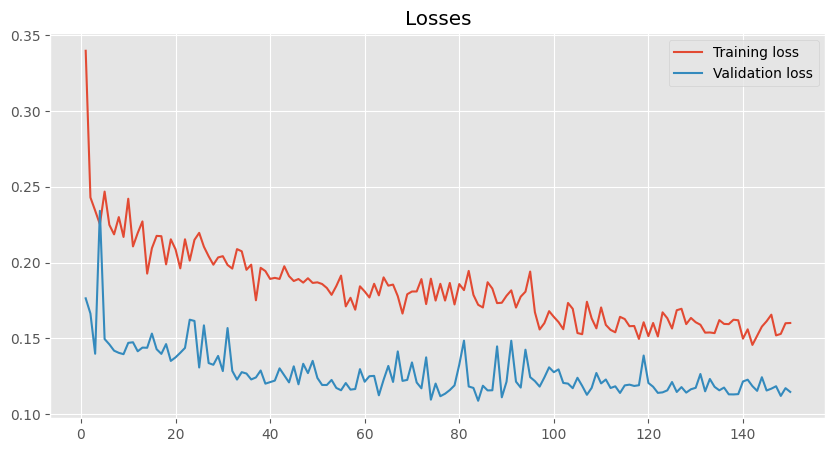

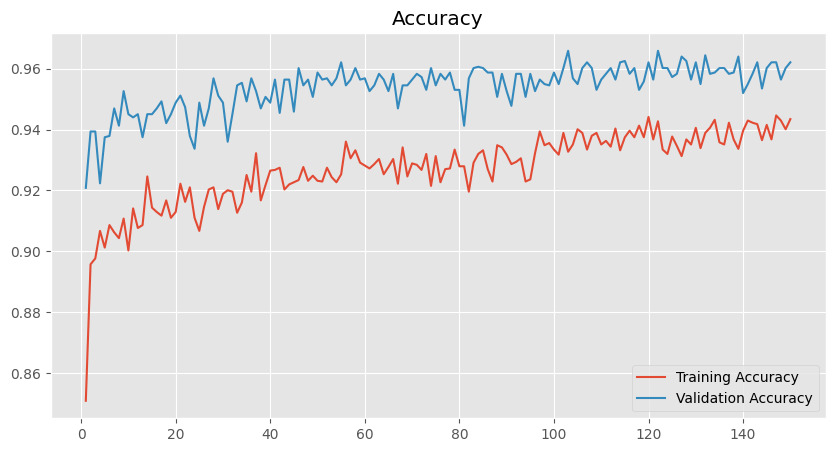

In [11]:
#################### perform training
# Define Optimizer and Loss Function
#loss_func = torch.nn.BCELoss() # binary cross entropy loss since we have only 2 classes
loss_func = torch.nn.BCEWithLogitsLoss() # binary cross entropy with sigmoid, no need to use sigmoid in the model
#loss_func = torch.nn.BCELoss()
# set Adam optimizer with learning rate 10^-3
optimizer = torch.optim.Adam(model.parameters(), lr = .001, weight_decay = .0005)

# a scheduler makes learning rate adaptive to the gradient descent optimization procedure, so you can increase performance and reduce training time 
# that is, reduces learning rate by a certain factor when less progress is being made in training.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, eps=1e-06)

num_epochs = 150

# training
train_losses, train_acc, val_losses, val_acc, model = train_it( model, train_dataloader, val_dataloader, num_epochs, scheduler, optimizer = optimizer, criterion = loss_func)
# visualize losses
visualization(train_losses,val_losses,'loss')
visualization(train_acc,val_acc,'acc')

Test function. Ground truth labels and predictions are returned.

In [12]:
# define testing function
def test_it( model, test_dloader):


	loss = 0
	testoutputs = []
	testlabels = []
	test_accs = []

	model.eval()
	with torch.no_grad():
        
		test_acc = 0
        # Validation loop
		for j, (test_inputs, test_labels) in enumerate(test_dloader):

			test_inputs = test_inputs.to(device)
			test_labels = test_labels.to(device)
            
            # Forward pass - compute outputs on input data using the model
			outputs = model(test_inputs)
            
            # # Compute loss
			# loss = loss_criterion(outputs, test_labels)
            
            # # Compute the total loss for the batch and add it to valid_loss
			# test_loss += loss.item() * test_inputs.size(0)
            
            # calculate  accuracy
			predictions = torch.round(torch.sigmoid(outputs.data))
			correct_counts = predictions.eq(test_labels.data.view_as(predictions))
			preds = [ int(predictions.cpu()[i]) for i in range(predictions.size(0)) ]
			tlabels = [ int(test_labels.cpu()[i]) for i in range(test_labels.size(0)) ]
            
            # convert correct_counts to float and then compute the mean
			acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # compute total accuracy in the whole batch and add to valid_acc
			test_acc += acc.item() 
        
			testoutputs.append(preds)
			testlabels.append(tlabels)

		avg_test_acc = test_acc/float(len(test_dloader))
		#print(" Test Accuracy: {:.4f}%".format( avg_test_acc*100))

		test_accs.append(avg_test_acc)


		testoutputs = [ testoutputs[i][j] for i in range(len(testoutputs)) for j in range(len(testoutputs[i])) ]
		testlabels = [ testlabels[i][j] for i in range(len(testlabels)) for j in range(len(testlabels[i])) ]


	return testoutputs, testlabels


In [18]:
# perform testing
test_outputs, test_labels = test_it(model,test_dataloader)

Compute some useful metrics such as accuracy, confusion matrix, sensitivity and specificity in order to judge the
reliability of our trained model

In [20]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true=test_labels,y_pred=test_outputs)
print(confusion_matrix)
tn, fp, fn, tp = confusion_matrix.ravel()
print('True Negative: {:2d}, False Positive: {:2d}, False Negative: {:2d}, True Positive: {:2d}'.format(tn,fp,fn,tp)) 

# accuracy indicates the total correctly classified data
total_data = sum(sum(confusion_matrix))
acc = (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / total_data
print("Accuracy: {:.4f}%".format(acc*100))

# sensitivity indicates the percentage of true positives that the model really recognised them as positive 
sensitivity = confusion_matrix[ 0, 0] / (confusion_matrix[ 0, 0] + confusion_matrix[ 0, 1])
print("Sensitivity: {:.4f}".format(sensitivity))

# specificity indicates the percentage of true negatives that the model really recognised them as negative
specificity = confusion_matrix[ 1, 1] / (confusion_matrix[ 1, 0] + confusion_matrix[ 1, 1])
print("Specificity: {:.4f}".format(specificity))

[[370  18]
 [ 11 125]]
True Negative: 370, False Positive: 18, False Negative: 11, True Positive: 125
Accuracy: 94.4656%
Sensitivity: 0.9536
Specificity: 0.9191


Considering the results, we can be suttisfied. But regarding that this was about to solve a medical problem with consequences on patients, there should be a more stable model with less false positives and false negatives. A possible improvement would be to further train the pretrained CNN model with Medical MNIST data (which contains thousands of xray and CT image data), and then use this pretrained CNN model as the basis for a CNN Xray images classifier. 